In this notebook, we check the distribution of the simulated data used in Monte Carlo simulations.

In [1]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import scipy.stats
from distribution_plots import *

## Description of the Monte Carlo simulation setup
Study level contrast estimates (denoted $\beta_i$'s) and contrast variance estimates (denoted $\sigma_i$'s) were simulated according to:
$$
\beta_i \sim \mathcal{N}(0, \sigma_i^2+\tau^2)
$$

$$
s^2_i \sim \chi^2_{n-1}*\frac{\sigma_i^2}{n-1}
$$

with 
$$
\sigma_i^2 = \frac{\sigma^2*a_i}{n}
$$

where:
 - $\tau^2=1$ is the between-study variance, 
 - $\sigma_i^2$ is the variance of contrast estimate for study i (i.e. the within-study variance divided by $n$) and 
 - $n=20$ is the number of subjects per studies.
 
6 different simulation schemes were computed:
 - 'diff': $\sigma^2_i \in \{0.25, 0.5, 1, 2, 4\}$
 - '05': $\sigma^2_i=\frac{5}{n}=0.25 \; \forall i$
 - '10': $\sigma^2_i=\frac{10}{n}=0.50 \; \forall i$
 - '20': $\sigma^2_i=\frac{20}{n}=1 \; \forall i$
 - '40': $\sigma^2_i=\frac{40}{n}=2 \; \forall i$
 - '80': $\sigma^2_i=\frac{80}{n}=4 \; \forall i$
 
A total of $38*30*30*30$ random sampling were computed for each simulation setting.

## Load simulation data

In [2]:
# Simulation parameters
nrep = 10; # 38 repeats are available
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep # Total number of realisations

tau2 = 1 # Between-study variance
nsubjects = 20 # Number of subjects per study

varcope_sigma2 = [0.25, 0.5, 1, 2, 4]
sigma2 = dict(('{num:02d}'.format(num=int(t*nsubjects)), 
               '$\\tau^2 = 1, \sigma^2_i = ' + str(t) + '$')  
              for t in varcope_sigma2) # Possible within-study variances (constant across studies)
sigma2['diff'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$'

kstudies = 25 # Number of studies in the meta-analysis (one-sample)
dof = nsubjects - 1 # Degrees of freedom

In [3]:
# Load the data
base_dir = '/Volumes/camille/IBMA_simu/'

wth_n20 = dict()

copes = dict() # mean_random_effects_var1.nii.gz concatenated across (independent) runs & voxels
varcopes = dict() # tstat1.nii.gz concatenated across (independent) runs & voxels

for wth in sigma2.keys():
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'cope.nii.gz')).get_data().reshape(-1,kstudies)
    if wth not in copes:
        copes[wth] = cope_array
    else:
        copes[wth] = np.append(copes[wth], cope_array, axis=0)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'varcope.nii.gz')).get_data().reshape(-1,kstudies)
    if wth not in varcopes:
        varcopes[wth] = varcope_array
    else:
        varcopes[wth] = np.append(varcopes[wth], varcope_array, axis=0)

In [4]:
wth_todisp = ['diff', '05', '80'] # Settings to be displayed
studies_todisp = [0, 24];

#### Check means

In [5]:
for wth in wth_todisp:
    print(np.mean(varcopes[wth], axis=0))
    print('----')
    print(np.mean(copes[wth], axis=0))

[ 0.24995807  0.50020218  0.99942988  2.00030017  4.00136423  0.25004339
  0.50020355  1.00061905  1.9986583   4.00248337  0.25002518  0.50062722
  0.99894512  2.00077868  3.99837089  0.25017121  0.50039786  0.99974841
  1.99887061  3.99870825  0.25009221  0.4995209   1.0002408   1.99865484
  4.00107908]
----
[ -1.63170043e-03   2.06742948e-03  -1.04147848e-03   4.58513480e-03
  -2.82856892e-03   2.26103561e-03   3.79459052e-05   2.12580455e-03
  -2.89333146e-03   3.91131826e-03  -1.70594372e-03   2.77753081e-03
   1.08181650e-03  -6.45270059e-03  -3.56993580e-04  -9.54225892e-04
   4.22293902e-04  -1.56106381e-03   2.04250857e-04   2.19480670e-03
   1.71464053e-03  -1.11274503e-03   1.54434165e-04   7.54994326e-05
  -3.83578963e-03]
[ 0.24995807  0.25010109  0.24985747  0.25003752  0.25008526  0.25004339
  0.25010177  0.25015476  0.24983229  0.25015521  0.25002518  0.25031361
  0.24973628  0.25009733  0.24989818  0.25017121  0.25019893  0.2499371
  0.24985883  0.24991927  0.25009221  

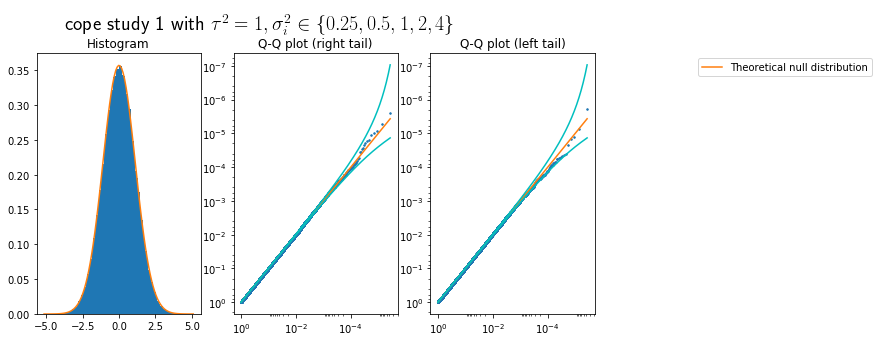

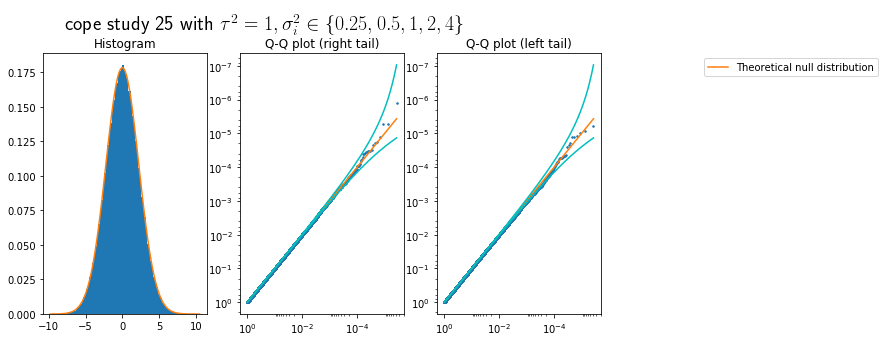

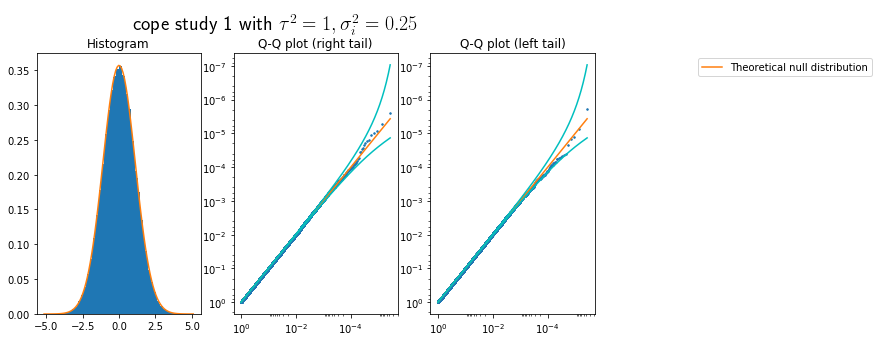

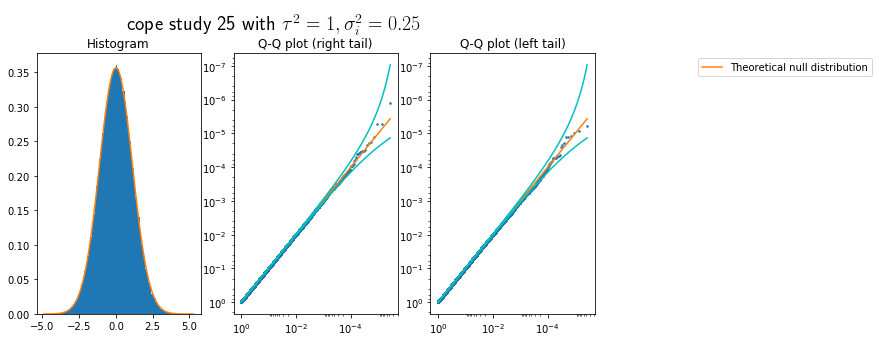

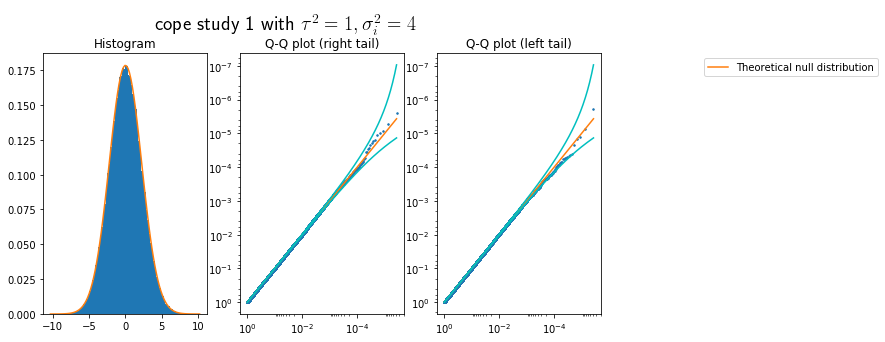

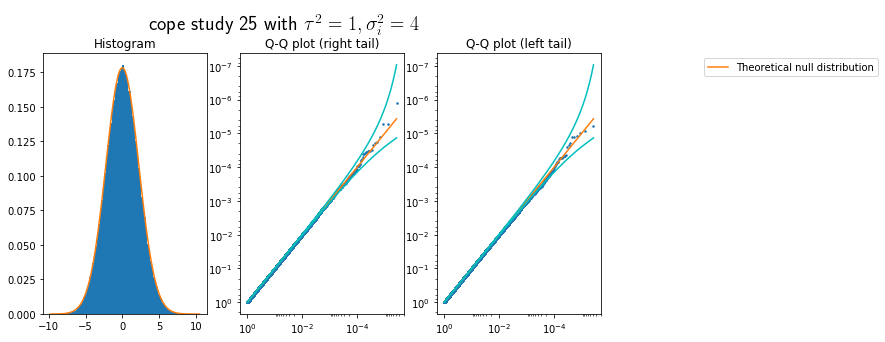

In [6]:
cope_th_var = dict()

diff_sigma_i_s = [0.25, 0.5, 1, 2, 4]

for i in range(kstudies + 1):
    cope_th_var['05',i] = 0.25 + tau2
    cope_th_var['80',i] = 4 + tau2
    cope_th_var['diff',i] = diff_sigma_i_s[i%5] + tau2

for wth in wth_todisp:
    for s in studies_todisp:
        z_distribution_plot(
            copes[wth][:,s], # cope to display
            'cope study ' + str(s+1) + ' with ' + sigma2[wth], # Title
            0, np.sqrt(cope_th_var[wth,s]) # Parameters of the theoretical Normal distribution
        )

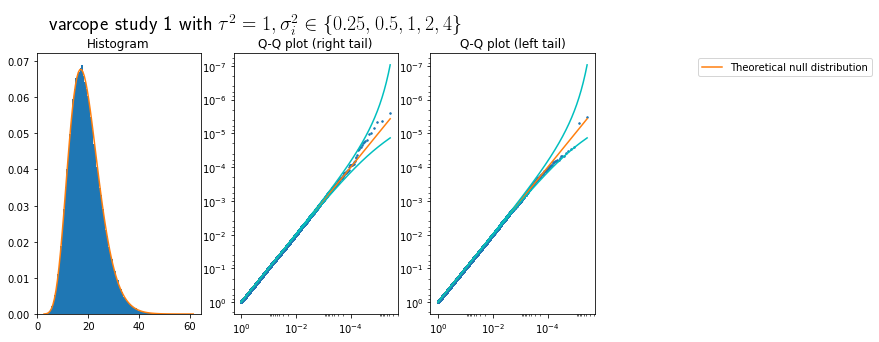

(18.923682096917673, 0.013208794172643111)


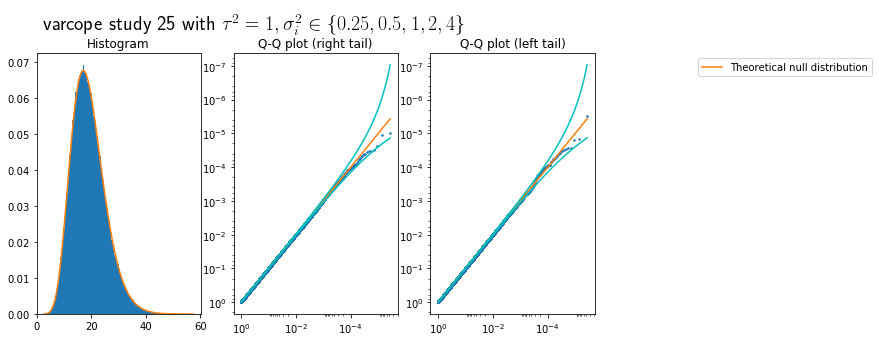

(19.023721014617355, 0.21032173293533163)


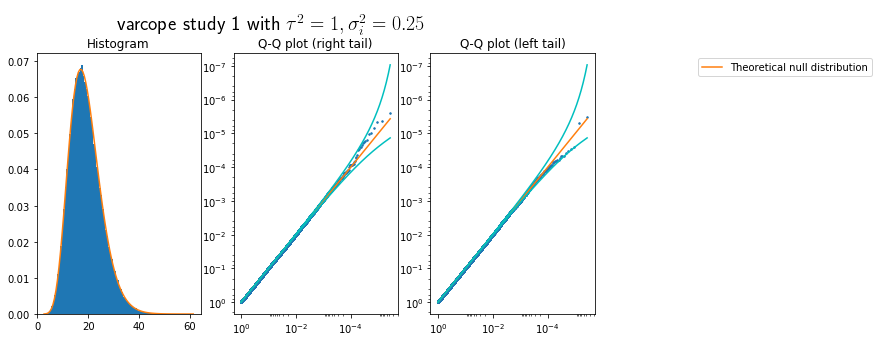

(18.923682096917673, 0.013208794172643111)


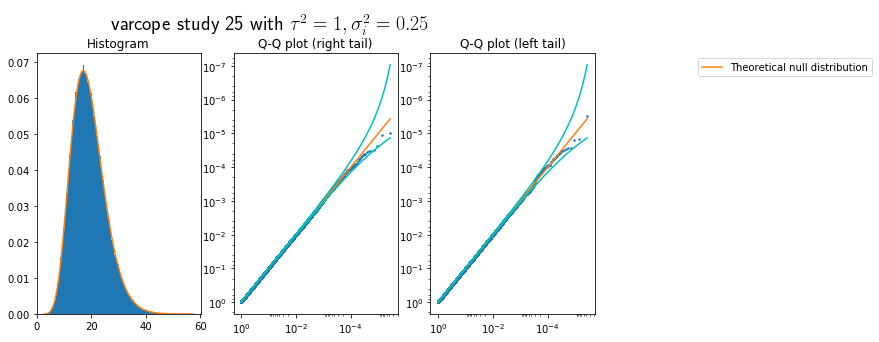

(19.023721014617355, 0.013145108308458227)


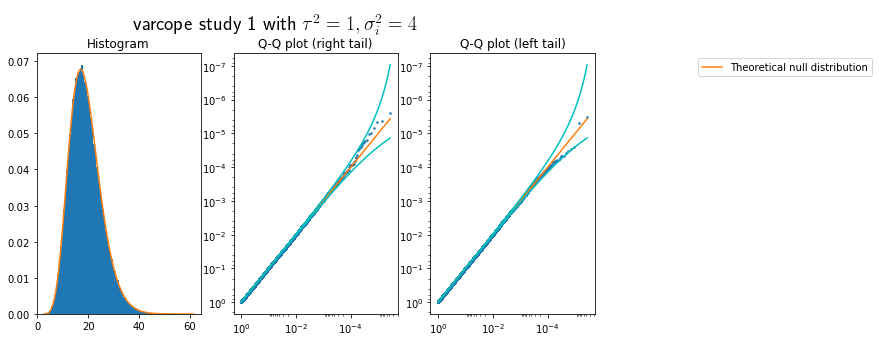

(18.923682096917673, 0.21134070676228978)


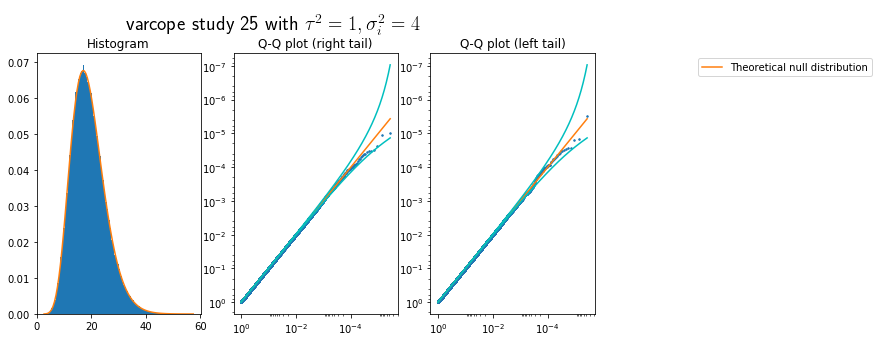

(19.023721014617355, 0.21032173293533163)


In [7]:
def get_chi2_params(X):
    Ex = np.mean(X)
    Vx = np.var(X)

    c = Vx/(2*Ex)
    nu = 2*np.power(Ex,2)/Vx
    return((nu,c))

for wth in wth_todisp:
    for s in studies_todisp:
        chi2_distribution_plot(
            varcopes[wth][:,s]/(cope_th_var[wth,s]-tau2)*dof, # scaled varcope to display
            'varcope study ' + str(s+1) + ' with ' + sigma2[wth], # Title
            dof # Parameters of the theoretical chi2 distribution
        )
        print(get_chi2_params(varcopes[wth][:,s]))